In [1]:
from pathlib import Path

In [2]:
import json
import glob

In [3]:
configs = []

for path in glob.glob(str(Path("output") / "state_*_config.json")):
    path = Path(path)

    with Path(path).open("r") as config:
        configs.append(json.load(config))

In [4]:
import numpy as np

In [5]:
def load_model_run(base_path: Path, ensemble_member: int, k: int = 36) -> np.ndarray:
    file_path = base_path.with_name(f"{base_path.name}_{ensemble_member}")

    return np.fromfile(file_path, dtype=np.double).reshape(-1, k)

In [6]:
def load_model_ensemble(base_path: Path, ensemble_size: int = 11, k: int = 36) -> np.ndarray:
    return np.stack([load_model_run(base_path, i, k=k) for i in range(ensemble_size)])

In [7]:
def ensemble_mean(ensemble: np.ndarray) -> np.ndarray:
    return np.mean(ensemble, axis=0)

In [8]:
def ensemble_spread(ensemble: np.ndarray) -> np.ndarray:
    return np.std(ensemble, axis=0)

In [9]:
import matplotlib
import proplot as plt

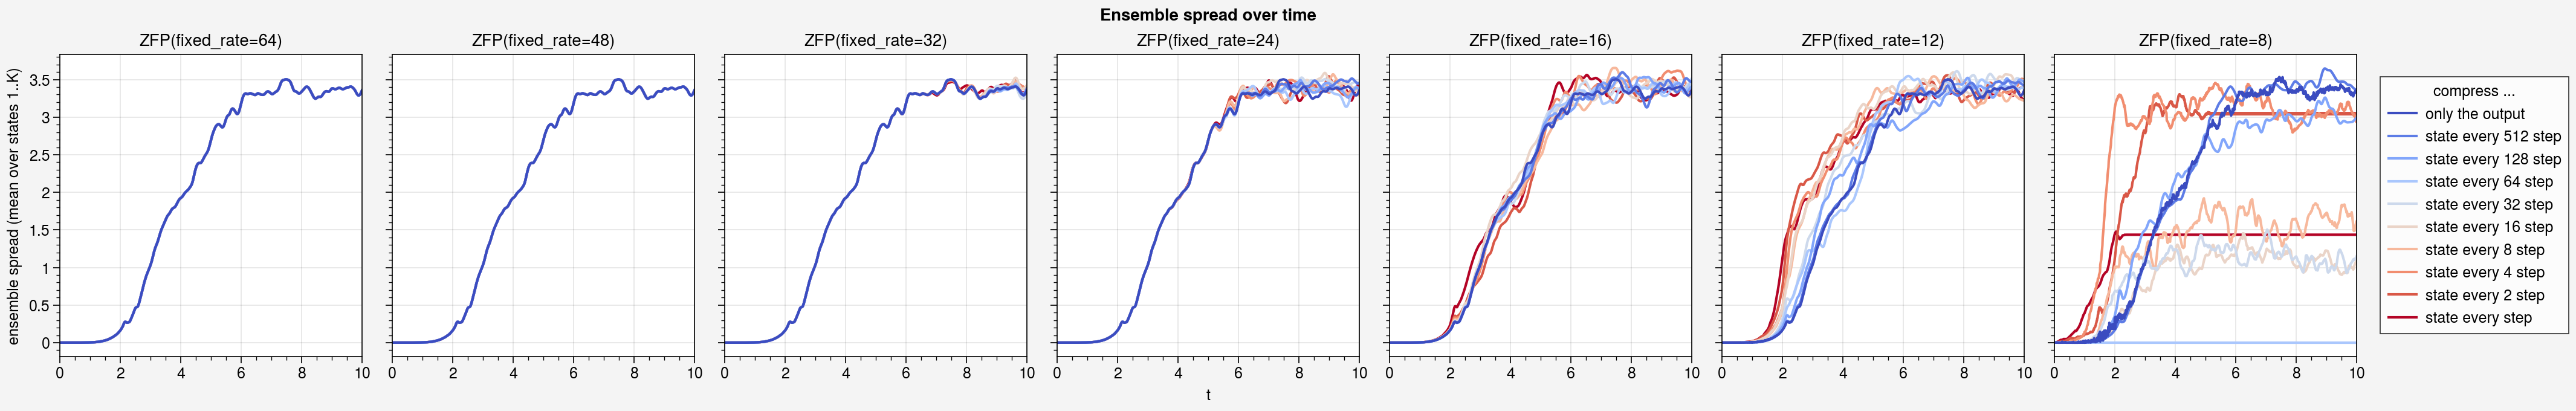

In [10]:
rates = sorted(set(c["zfp_fixed_rate"] for c in configs), reverse=True)

fig, axs = plt.subplots(nrows=1, ncols=len(rates))
fig.format(suptitle="Ensemble spread over time")

for rate, ax in zip(rates, axs):
    rate_configs = [c for c in configs if c["zfp_fixed_rate"] == rate]
    rate_configs = sorted(
        rate_configs,
        key=lambda c: (
            c["compression_frequency"]
            if c["compression_frequency"] == 0
            else -1/c["compression_frequency"]
        ),
    )

    colors = matplotlib.pyplot.cm.coolwarm_r(np.linspace(0.0, 1.0, len(rate_configs)))
    cycle = plt.Cycle(colors=colors)
    
    for config in rate_configs:
        ensemble = load_model_ensemble(Path(config["output"]))

        c = config["compression_frequency"]
    
        if c < 0:
            label = "nothing"
        elif c == 0:
            label = "only the output"
        else:
            label = f"state every {c if c != 1 else 'step'}{' step' if c != 1 else ''}"
    
        ax.plot(
            np.arange(ensemble.shape[-2]) * config["dt"],
            np.mean(ensemble_spread(ensemble), axis=1),
            label=label, cycle=cycle,
        )
    
    ax.set_title(f"ZFP(fixed_rate={config['zfp_fixed_rate']})")
    ax.set_xlabel("$t$")
    ax.set_ylabel("ensemble spread (mean over states 1..K)")
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], title="compress ...", loc="right", ncols=1)
    
plt.show()

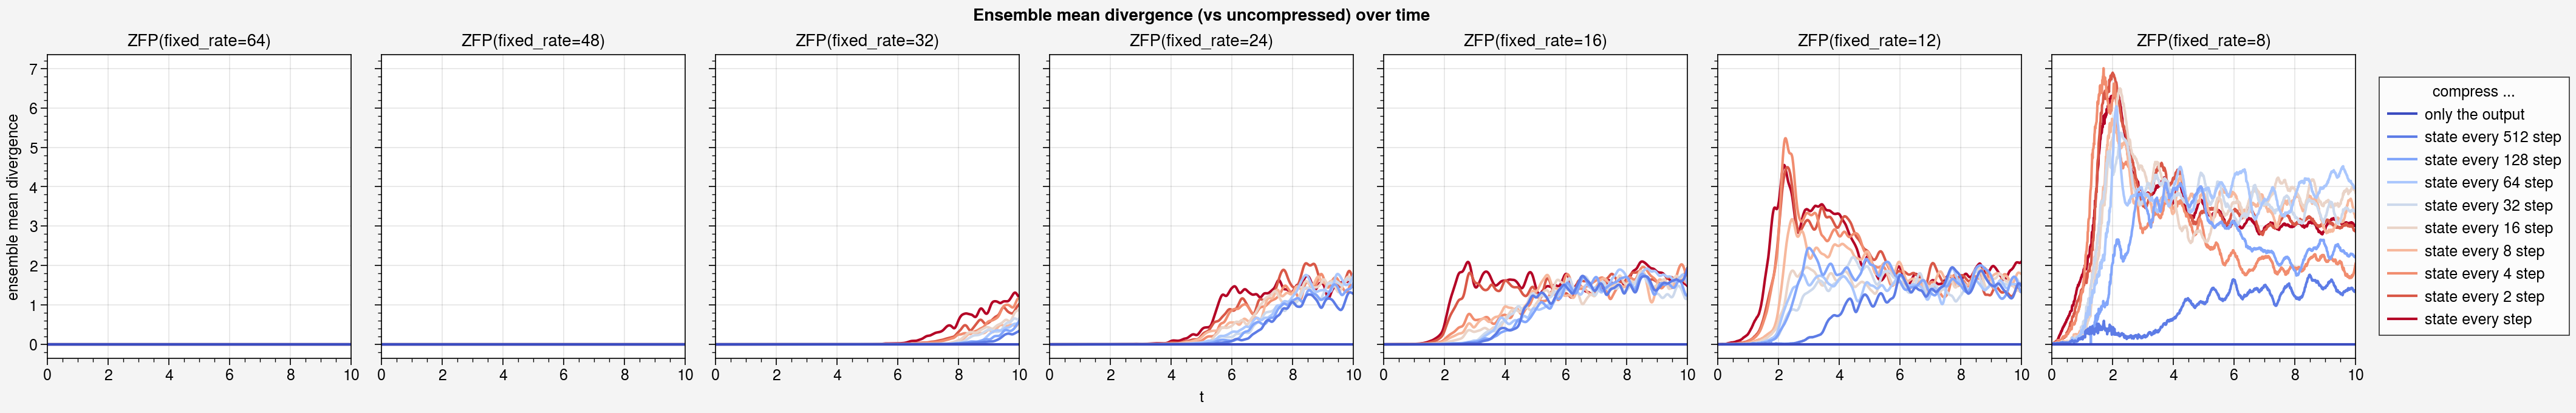

In [11]:
rates = sorted(set(c["zfp_fixed_rate"] for c in configs), reverse=True)

fig, axs = plt.subplots(nrows=1, ncols=len(rates))
fig.format(suptitle="Ensemble mean divergence (vs uncompressed) over time")

for rate, ax in zip(rates, axs):
    rate_configs = [c for c in configs if c["zfp_fixed_rate"] == rate]
    rate_configs = sorted(
        rate_configs,
        key=lambda c: (
            c["compression_frequency"]
            if c["compression_frequency"] == 0
            else -1/c["compression_frequency"]
        ),
    )

    base_ensemble = load_model_ensemble(
        next(Path(c["output"]) for c in rate_configs if c["compression_frequency"] == 0)
    )
    base_ensemble_mean = ensemble_mean(base_ensemble)

    colors = matplotlib.pyplot.cm.coolwarm_r(np.linspace(0.0, 1.0, len(rate_configs)))
    cycle = plt.Cycle(colors=colors)
    
    for config in rate_configs:
        ensemble = load_model_ensemble(Path(config["output"]))

        c = config["compression_frequency"]
    
        if c < 0:
            label = "nothing"
        elif c == 0:
            label = "only the output"
        else:
            label = f"state every {c if c != 1 else 'step'}{' step' if c != 1 else ''}"
    
        ax.plot(
            np.arange(ensemble.shape[-2]) * config["dt"],
            (
                np.linalg.norm(ensemble_mean(ensemble) - base_ensemble_mean, axis=1)
                / np.sqrt(base_ensemble_mean.shape[-1])
            ),
            label=label, cycle=cycle,
        )
    
    ax.set_title(f"ZFP(fixed_rate={config['zfp_fixed_rate']})")
    ax.set_xlabel("$t$")
    ax.set_ylabel("ensemble mean divergence")
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], title="compress ...", loc="right", ncols=1)
    
plt.show()

In [ ]:
rates = sorted(set(c["zfp_fixed_rate"] for c in configs), reverse=True)
frequencies = sorted(
    set(c["compression_frequency"] for c in configs),
    key=lambda c: c if c == 0 else -1/c
)

fig, axs = plt.subplots(nrows=len(frequencies), ncols=len(rates))

axs.format(
    toplabels=[
        f"ZFP(fixed_rate={r})" for r in rates
    ],
    leftlabels=[
        "no compression" if c < 0
        else "compress only the output" if c == 0
        else f"compress state every {c if c != 1 else 'step'}{' step' if c != 1 else ''}"
        for c in frequencies
    ],
    xlabel="$t$",
    ylabel="$X_{k=0}$",
)

axs = np.array(axs).reshape((len(frequencies), len(rates)))
fig.format(suptitle="Ensemble divergence (vs uncompressed) over time")

for rate, axc in zip(rates, axs.T):
    rate_configs = [c for c in configs if c["zfp_fixed_rate"] == rate]
    rate_configs = sorted(
        rate_configs,
        key=lambda c: (
            c["compression_frequency"]
            if c["compression_frequency"] == 0
            else -1/c["compression_frequency"]
        ),
    )

    base_ensemble = load_model_ensemble(
        next(Path(c["output"]) for c in rate_configs if c["compression_frequency"] == 0)
    )
    base_ensemble_mean = ensemble_mean(base_ensemble)
    base_ensemble_spread = ensemble_spread(base_ensemble)

    colors = matplotlib.pyplot.cm.coolwarm_r(np.linspace(0.0, 1.0, len(rate_configs)))
    cycle = plt.Cycle(colors=colors)
    
    for i, (config, ax) in enumerate(zip(rate_configs, axc)):
        ensemble = load_model_ensemble(Path(config["output"]))

        c = config["compression_frequency"]
    
        if c < 0:
            label = "nothing"
        elif c == 0:
            label = "only the output"
        else:
            label = f"state every {c if c != 1 else 'step'}{' step' if c != 1 else ''}"

        ax.fill_between(
            np.arange(ensemble.shape[-2]) * config["dt"],
            base_ensemble_mean[:,0] - base_ensemble_spread[:,0],
            base_ensemble_mean[:,0] + base_ensemble_spread[:,0],
            alpha=0.4, color=colors[-1],
        )
        ax.plot(
            np.arange(ensemble.shape[-2]) * config["dt"],
            base_ensemble_mean[:,0],
            color=colors[-1], ls=":",
        )

        ax.fill_between(
            np.arange(ensemble.shape[-2]) * config["dt"],
            ensemble_mean(ensemble)[:,0] - ensemble_spread(ensemble)[:,0],
            ensemble_mean(ensemble)[:,0] + ensemble_spread(ensemble)[:,0],
            alpha=0.5, color=colors[i],
        )
        ax.plot(
            np.arange(ensemble.shape[-2]) * config["dt"],
            ensemble_mean(ensemble)[:,0],
            label=label, color=colors[i],
        )
    
plt.show()